# Source, Original notebook
 - https://github.com/acids-ircam/diffusion_models
 - https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_02_model.ipynb

# Diffusion probabilistic models - introduction

#### Author : Philippe Esling (esling@ircam.fr)
- Translator(Korean) : Jeongseob Kim (jeongseob_kim@korea.ac.kr)

이 2번째 노트북에선 _diffusion probabilistic models_ [ [ 1 ] ](#ref1)를 계속해서 탐색해나갈 것이다.
본 노트북 시리즈는 아래와 같고, 이 노트북은 2번째에 해당한다.

   1. Score matching and Langevin dynamics.
   2. Diffusion probabilistic models and denoising
   3. Applications to waveforms with WaveGrad
   4. Implicit models to accelerate inference

Diffusion model을 본격적으로 살펴보기에 앞서, 바로 전 노트북에서 살펴보았던 _score matching_ [ [ 3 ] ](#ref3)와 _Langevin dynamics_ 에 대해 다시 간단히 살펴볼 것이다. 그리고 diffusion probabilistic model의 origianl formulation을 소개할 것이다. 이 original formulation은 thermodynamics [ [ 2 ] ](#ref2)에 기반하고 있다. 그리고 더 최근에 관련한 formulation들은 _denoising_ [ [ 1 ] ](#ref1)와 관련되어있다.

## Theoretical bases - quick recap

이번 섹션에서는 바로 전 노트북에서 살펴본 **score matching**의 개념을 간단히 recap할 것이다. 이전과 같이 _swiss roll_ 데이터를 바탕으로 진행한다.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


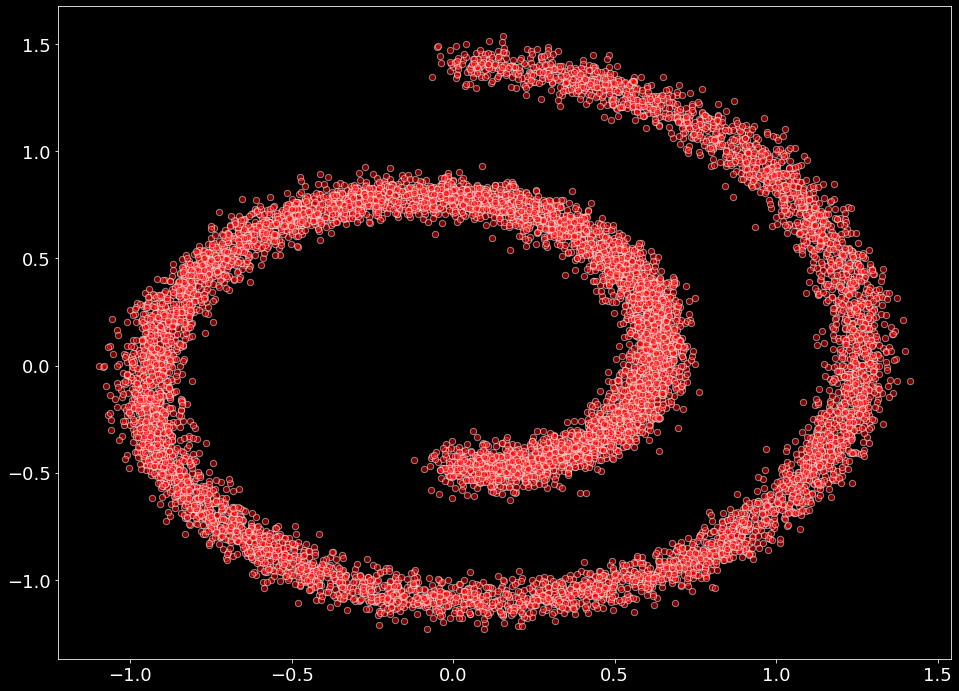

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()

from copy import deepcopy as copy
from torch.distributions.normal import Normal

# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)
plt.show()

### Score matching

_Score matching_ 은 $\log p(\mathbf{x})$ with respect to $\mathbf{x}$의 _gradients_ (termed _score_)를 학습하는 데 목적을 둔다. Probabilistic function인 $\log p(\mathbf{x})$를 직접 학습하려고 하지 않는다. 따라서 우리는 아래를 근사(approximate)하는 모델을 찾을 것이다. _Score matching_ 을 통해..

$$
\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})
$$

우리는 이를 MSE objective로 최적화하는 것이 곧 아래의 식을 최적화하는 것과 같다는 것을 지난 노트북에서 살펴본 바 있다.

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
$$

위 식에서 $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$는 Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$을 의미한다.

이러한 최적화 문제의 공식(formulation)은 Jacobian 계산 상에서 high-dimensional data에는 scalability(데이터가 차원이 커지면, 연산의 어려움 가중)가 잘 확보되지 않는 다는 문제를 안고 있다. 이 문제로 인해 아래와 같은 _Sliced score matching_ 이라는 보다더 효율적인 optimization objective forumulation이 도출된다. 이 _Sliced score matching_ 은 _Random projections_ 를 활용해 Jacobian의 계산을 보다 효율적으로 하고자 한다.

$$ E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
$$

$\mathbf{v} \sim \mathcal{N}(0, 1)$는 Normal-distributed 벡터를 의미한다. 이렇게 _Random projection_ 을 이용하면 위의 식은 forward mode auto-differentiation을 활용해 계산될 수 있다. 이는 곧 _Sliced score matching_ 이 보다 효율적인 연산을 할 수 있다는 의미이다. _Sliced score matching_ 은 아래와 같이 구현할 수 있다.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

#### Denoising score matching

본래 _denoising score matching_ 은 Vincent [ [ 3 ] ](#ref3)에 의해 처음 논의되었었다. 이 때는 _denoising auto-encoders_ 의 맥락에서 _denoising score matching_ 의 개념이 논의되었었다. Score matching의 관점에서는 score matching 계산에서 $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$를 완전히 제거할 수 있다. 대신 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$ 분포를 통해 input을 noisy하게 만든다(corrupting). _denoising score matching_ 은 아래와 같은 objective를 최적화함으로써 score matching($\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$)을 이뤄낼 수 있다.

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

위 식에서 중요한 점은 $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$는 오직 noise가 $q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$일 만큼 작아야 성립한다는 점이다. 따라서 noise distribution을 무엇으로 정의하느냐는 매우 중요하다. 만약 우리가 noise distribution을 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$로 정의한다면, $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$와 같은 등식이 성립할 수 있다([ [ 3 ] ](#ref3),[ [ 8 ] ](#ref8)). 이에 따라 위의 _denoising score matching_ objective는 아래와 같이 더 간단해질 수 있다.

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
$$

위의 _denoising score matching_ loss를 아래와 같이 정의할 수 있다.

In [3]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

최적화 과정은 $\mathcal{F}_{\theta}(\mathbf{x})$를 Neural Network를 기반으로 free-form으로 매우 간단하게 구현할 수 있다. 아래와 같이 미니멀하게 모델을 구현(the minimalistic implementation)해본다.

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
).to(device)

model_nottrained = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
).to(device)

# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float().to(device)
losses = []
for t in range(5000*10):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 10000) == 0):
        print(loss)
    losses.append(float(loss))

tensor(9956.4785, device='cuda:0', grad_fn=<MulBackward0>)
tensor(9869.6914, device='cuda:0', grad_fn=<MulBackward0>)
tensor(9899.6689, device='cuda:0', grad_fn=<MulBackward0>)
tensor(9917.5762, device='cuda:0', grad_fn=<MulBackward0>)
tensor(10038.1104, device='cuda:0', grad_fn=<MulBackward0>)


우리는 이 모델이 _denoising score matching_ 을 제대로 학습해냈는 지를 input space에 output(gradient)를 plotting해봄으로써 확인해볼 수 있다.

$$\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$$

In [5]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)

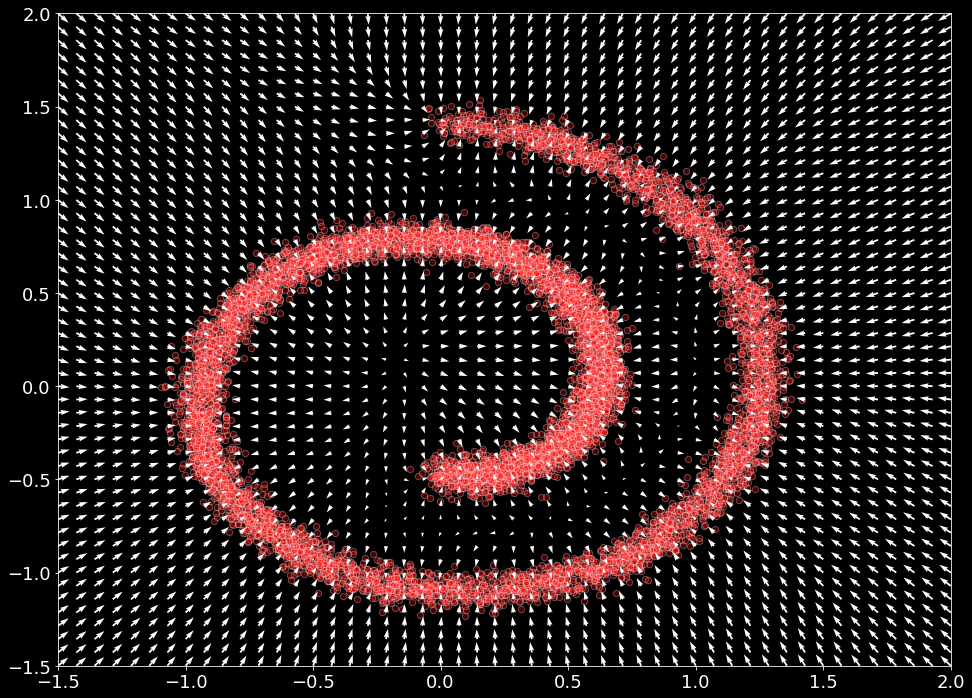

In [6]:
plot_gradients(model.to('cpu'), data)

아래와 같이 _denoising score matching_ 에 따른 학습(최적화)를 진행하지 않은 모델의 경우 output(gradient)가 density를 따라 quiver plot이 그려지지 않는 것을 볼 수 있다. 따라서 위의 모델은 학습을 잘 진행한 것임을 간단하게 알 수 있다.

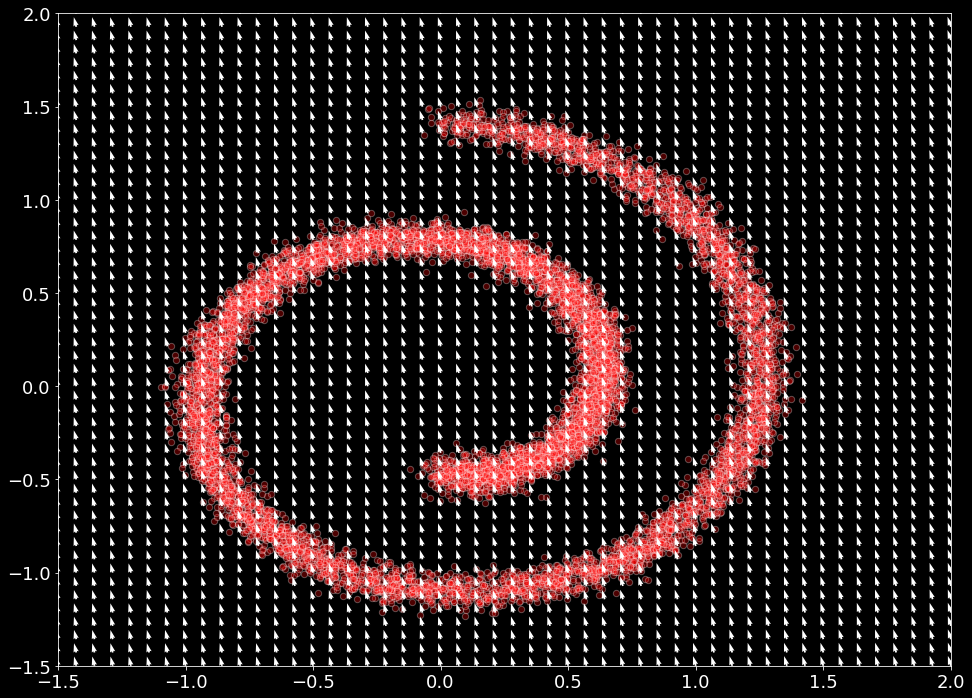

In [7]:
plot_gradients(model_nottrained.to('cpu'), data)

### Langevin sampling

우리는 지난 노트북에서 _Langevin dynamics_ 가 density $p(\mathbf{x})$로부터 true sample을 만들어낼 수 있음을 확인한 바 있다. 이는 score($\nabla_{\mathbf{x}} \log p(\mathbf{x})$)를 기반으로 가능하고, langevin dynamics를 통해 확인 가능하다.

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

- $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$
- $\epsilon \rightarrow 0, t \rightarrow \inf$

위의 2가지 사항이 만족될 때, $\mathbf{x}_t$는 density $p(\mathbf{x})$에서 추출한 sample로 정확하게 수렴(converge)하게 된다.
- 이것이 바로 _score-based generative modeling_ 접근법의 Key idea이다.

In [8]:
def sample_langevin(model, x, n_steps=10, eps=1e-3, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

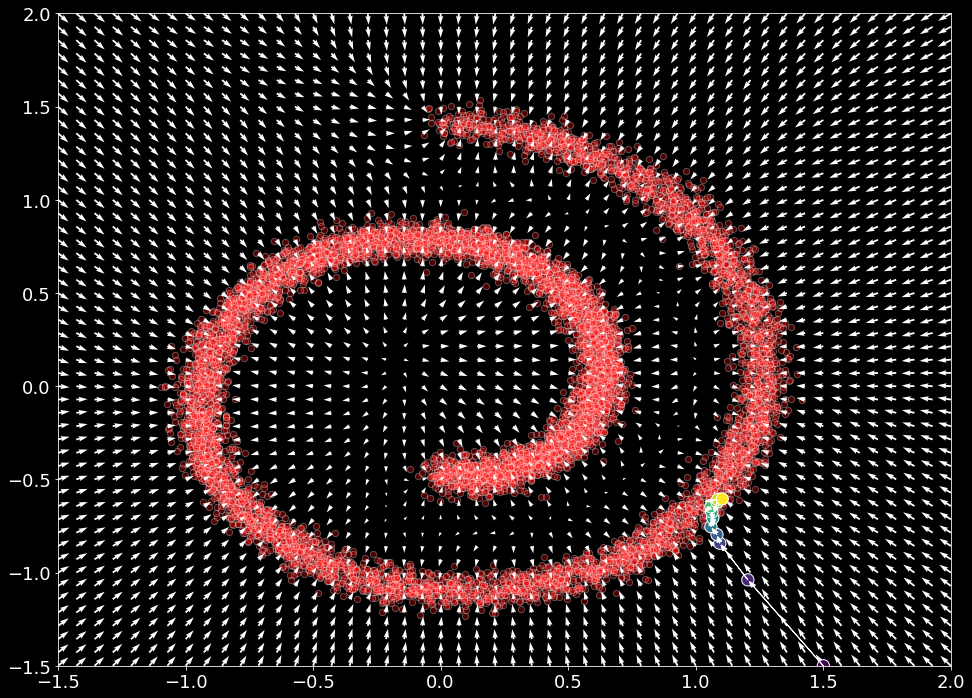

In [9]:
x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x, eps=(1e-3)*1.5).detach()

C = np.linspace(0, 30, len(samples))
plot_gradients(model.to('cpu'), data)
plt.scatter(samples[:, 0], samples[:, 1], c=C, edgecolor='white', s=150)

# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / torch.tensor(np.linalg.norm(deltas, keepdims=True, axis=-1)) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color='white', linewidth=1)

## Diffusion models

_Diffusion probabilistic models_ 는 Sohl-Dickstein et al. [ [ 1 ] ](#ref1)에 의해 2015년 비평형 열역학(non-equilibrium thermodynamics)에 근거해 처음 제안됐다. 이러한 모델들은 주로 상호 호혜적인 과정(reciprocal processes)에 근거하고 있다. 여기서 상호 호혜적인 과정은 확률변수들의 2개의 markov chains을 의미한다. 이 상호 호혜적인 과정은 아래와 같다.

1. $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ : Diffusion or Forward process
    - 점진적으로(gradually) input data에 noise를 더해가는 과정
        - 결국, noise로 가득해 original signal(input data)는 뭉개(destroy)진다.
        
        
2. $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ : Reverse process
    - 어떻게 하면 Diffusion process를 거꾸로(invert) 뒤집을 수 있는 지를 학습한다(= denoising process)
        - 결국, Random noise를 high-quality의 특정한 파형(waveform), 패턴으로 변환해냄.
        
아래의 figure는 이러한 1.와 2.의 과정을 잘 표현하고 있다.

<img src="images/diffusion.png" width="100%"/>

Figure에서 볼 수 있듯 
- _Forward_ (and Fixed) process $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ 는 점진적으로 매 단계마다 noise를 더해간다. 
- 반대로, _reverse_ (parametric) proces $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ 는 어떻게 이 local perturbations(noise로 오염된 local)을 _denoise_ 할 것인지를 반드시 배워야 한다.

따라서, '학습(learning)'은 _**large** number of **small** perturbations_ 를 추정(estimate)하는 것을 포함한다. 그리고 이러한 '학습'은 단 하나의 potential function으로 전체 분포(full distribution)을 직접 추정하려는 시도보다 훨씬 tractable하다.

이 2가지 process(Diffusion, Reverse)는 모두 'parameterized Markov chains'로 볼 수 있다(따라서 앞서 2가지 확률변수의 markov chains간 reciprocal process라고 한 것). 
- 하지만 _diffusion_ process는 각 단계마다 미리 선정된 양 만큼만 noise를 주입하도록 항상 단순화된다.
- _reverse_ process는 variational inference를 사용하도록 학습(trained)된다
    - 학습은 reverse process에서 일어난다. diffusion process는 학습하는 단계가 아니다. 정해진 조그만 양의 noise를 추가해나가는 수많은 반복 과정일 뿐이다.
        - 이 variational inference는 주로 conditional gaussians로 모델링이 되어 수행된다. 
        - conditional gaussians는 Neural network parameterization과 tractable estimation을 가능하게 한다.

### Formalization

Diffusion 모델은 input data와 동일한 차원(dimensionality)를 갖는 잠재변수들 $ \mathbf{x}_{1},\cdots,\mathbf{x}_{T}$에 기반한다. 이러한 잠재변수들은 $\mathbf{x}_{0} \sim q(\mathbf{x}_{0})$로 보통 정의(labeled)된다. 이러한 잠재변수($ \mathbf{x}_{1},\cdots,\mathbf{x}_{T}$)와 분포($\mathbf{x}_{0} \sim q(\mathbf{x}_{0})$)를 바탕으로 아래와 같이 두 process를 정의할 수 있다.

- the two Markov chains..

$$
\text{forward (diffusion)} : q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$
$$
\text{reverse (parametric)} : p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

#### Forward process

forward process에서는 data distribution $q(\mathbf{x}_{0})$는 점진적으로 analytically tractable한 $\pi(\mathbf{y})$ 분포로 변환된다. 이 변환 과정은 반복적인 Markvo diffusion kernel $T_{\pi}(\mathbf{y}\mid\mathbf{y}';\beta)$의 적용을 통해 이뤄진다.
- Markov diffusion kernel은 $\beta$라는 given 'diffusion rate'에 의해 정의됨

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = T_{\pi}(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}; \beta_{t})
$$

Markov diffusion kernel은 variance schedule $\beta_{1},\cdots,\beta_{T}$에 따라 점진적으로 Gaussian noise를 주입해가는 kernel을 의미한다. 수식은 아래와 같다.

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Markov chains 전 과정에 걸친 분포(the complete distribution) $q(\mathbf{x}_{0:T})$는 아래와 같은 _diffusion process_ 라고 불리운다.

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$


아래에서 단일 상수 분산(a constant variance)으로 'variance schedule'을 정의해 간단한 _forward diffusion process_ 를 구현해본다.

- 아래의 ```forward_process```는 gaussian distribution에서 sampling할 때, reparameterization을 진행하는 것을 참고해 아래와 같은 방식으로 구현한다.

$$x_{t} = \sqrt{1-\beta_{t}} x_{t-1} + \sqrt{\beta_{t}} * \epsilon$$

- stochasticity는 $\epsilon$ 에서 발생한다.
- $\beta$ 는 hyper-parameter로서(trainable X) 사전에 정의하는 variance scehdule에 따라 정의된다.

In [10]:
def forward_process(x_start, n_steps, noise=None):
    """ 
    Diffuse the data (t == 0 means diffused for 1 step) 
    
    x_start:tensor = dataset at start step(X_0)
    n_steps:int = the number of convert iterations in diffusion process
    """
    x_seq = [x_start] # initial 'x_seq' which is filled with origianl data at first.
    for n in range(n_steps):
        # Add gaussian noise with 'scaling with squared term and transition with beta * [0,1) unique dist'
        # Gaussian noise is '''torch.rand_like(x_start)''' in following code
        x_seq.append((torch.sqrt(1 - noise[n]) * x_seq[-1]) + (noise[n] * torch.rand_like(x_start)))
    return x_seq

**Small iterative step(1, 2) of diffusion process**

- function 'forward_process'

아래와 같은 original data를 gaussian noise를 더해주며 diffusion시킬 것이다. 1step의 diffusion process의 영향을 직접 확인해보며 이해를 더해보자.

swiss roll data shape : (2, 10000)


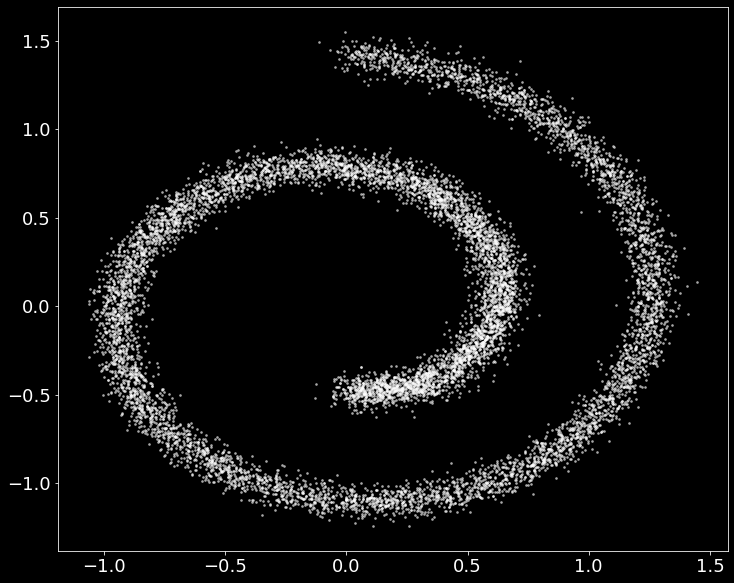

In [11]:
# Original data X_0

data = sample_batch(10**4, noise=0.5).T
print(f"swiss roll data shape : {data.shape}")
plt.figure(figsize=(12,10))
plt.scatter(*data, alpha=0.5, s=3, color='white')
plt.show()

Diffused swiss roll data shape : torch.Size([2, 10000])


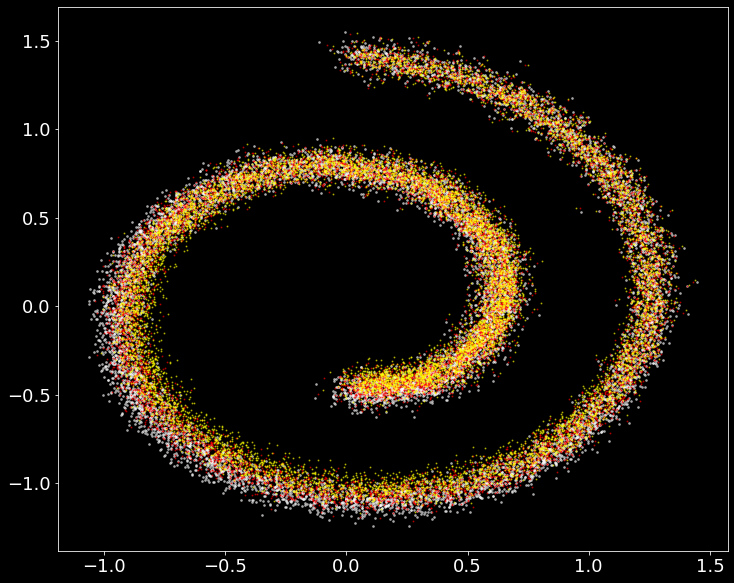

In [12]:
beta = torch.FloatTensor([0.035])
diffused_1_data = torch.sqrt(1 - beta) * data + beta * torch.rand_like(torch.tensor(data))
diffused_2_data = torch.sqrt(1 - beta) * diffused_1_data.clone().detach() + beta * torch.rand_like((diffused_1_data).clone().detach())

print(f"Diffused swiss roll data shape : {diffused_1_data.shape}")
plt.figure(figsize=(12,10))
plt.scatter(*data, alpha=0.5, s=3, color='white')
plt.scatter(*diffused_1_data, alpha=0.5, s=1, color='red')
plt.scatter(*diffused_2_data, alpha=0.5, s=1, color='yellow')
plt.show()

**100 steps of diffusion process**

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


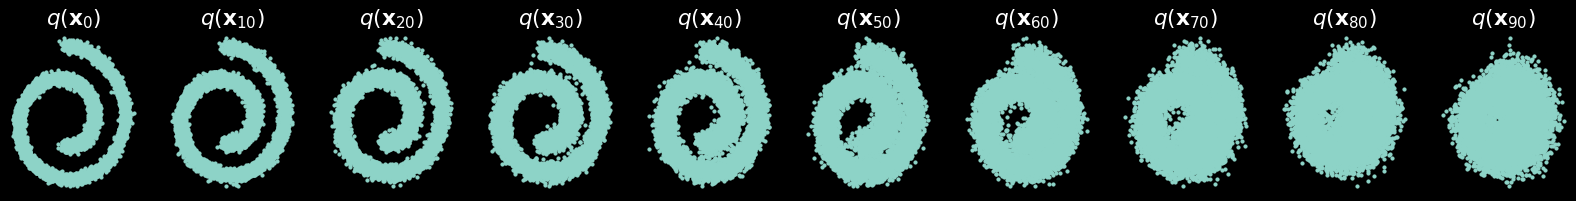

In [13]:
n_steps = 100
betas = torch.tensor([0.035] * n_steps) # betas : variance schedule [0.035, 0.035, 0.035, ...]
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')

위의 실험에서는 variance schedules를 동일한 값($\beta_{1} = \cdots = \beta_{n} = 0.35$)으로 주었지만, 아래의 함수를 정의해 자유롭게 variance scheules를 정의할 수 있다.

- **linear** schedule
- **Quad** schedule
- **Sigmoid**' schedule

In [14]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

흥미롭게도, _forward process_ 는 sampling $\mathbf{x}_{t}$를 특정한 임의의 시점 $t$에서 가능하게 한다. Notation으로 $\alpha_{t}=1-\beta_{t}$와 $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$로 축약해 **시점 $t$에서의 $\mathbf{x}_{t}$ sampling을 아래와 같이 정리할 수 있다.**

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0},(1-\bar{\alpha}_{t})\mathbf{I})
$$

- Original ipynb에서는 Sampling에 대한 수식이 위와 다르다. $q(\mathbf{x}_{t}\mid\mathbf{x}_{0})$이  $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$로, $\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0}$가 $\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1}$로 제시되어있다. 이는 제 개인적인 판단에 따라 번역 중에 변형한 것이다. 아래 코드에서도 마찬가지로 ```q_sample```에서 입력 데이터($x_{0}$)를 받아 $t$시점의 diffused data sample을 반환하도록 되어있다. 그리고 이는 결국 입력 데이터에서 시작해 markov diffused kernel의 누적적인 영향($\sqrt{\bar{\alpha}}$)을 반영해 $t$시점의 diffused data sample을 반환하는 것이다. 따라서 위와 같이 입력 데이터를 조건부로 $t$시점의 diffused data sample을 반환하는 것으로 수식의 표기를 변경했다(만약, 위 해석과 변경에 오류가 있다면, 꼭 제 [이메일](jeongseob_kim@korea.ac.kr)로 연락주시면 감사드리겠습니다.). 


그러므로 우리의 diffusion sampling 함수를 이러한 mechanism에 따라 update할 수 있다. 잊지 말아야 할 것은 이러한 sampling mechanism은 사전적으로 정의한 variance schedule $\beta_{1},\cdots,\beta_{T}$에 따라 이뤄진다는 점이다.

In [15]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

이처럼 **시점 $t$에서의 $\mathbf{x}_{t}$ sampling**이 Markov diffusion kernel로서 정의된다는 점은 임의의 특정 $t$시점에서 혹은 원하는 아무 시점에서나 직접 sampling을 해낼 수 있게 한다는 점으로 매우 효율적인 forward process를 가능하게 한다. 아래와 같이 코드로 구현 가능하다.

In [16]:
def extract(input, t, x):
    '''
    Extract value 'alpha_bar_sqrt', 'one_minus_alpha_bar_sqrt' at any given 't' step.
    '''
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_sample(x_0, t, noise=None):
    '''
    Sampling at any given 't' step.
    '''
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0).to(device)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0).to(device)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

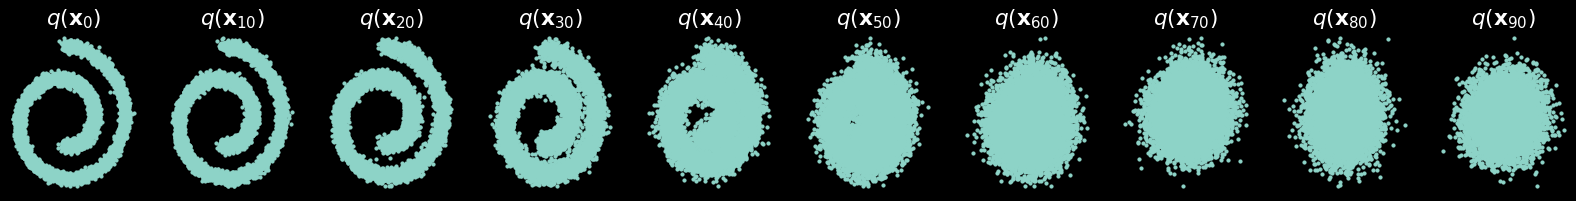

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(dataset.to(device), torch.tensor([i * 10]).to(device))
    axs[i].scatter(q_i[:, 0].to('cpu'), q_i[:, 1].to('cpu'), s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

학습을 위해선 본 _diffusion process_ 로 얻은 posterior distribution 의 mean, variance에 대한 접근이 가능 해야한다.

- Posterior of _diffusion process_ $q(x_{1:t}|x_{0}$) 의 mean, variance의 도출 과정에 대한 설명은 [Original paper(2020)](https://arxiv.org/abs/2006.11239)에서 확인할 수 있다.

In [18]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [19]:
def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0).to(device)
    coef_2 = extract(posterior_mean_coef_2, t, x_0).to(device)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

#### Reverse process

우리가 학습하고자 하는 생성적 분포(generative distribution)는 "reverse trajectory"를 수행하도록 학습될 것이다. 이 "reverse trajectory"는 gaussian noise에서 시작해 점진적으로 local perturbations들을 제거해나갈 것이다(denoising process). 그러므로 "reverse prcocess"는 주어진 tractable distribution $p(\mathbf{x}_{T})=\pi(\mathbf{x}_{T})$ 에서 시작할 것이다. 이는 아래와 같다.

$$
p_{\theta}(\mathbf{x}_{0:T}) =  p(\mathbf{x}_{T}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

해당 process("reverse")의 각 변환(transition)은 간단한 conditional gaussians(VAE를 연상시키는)로 정의된다. 그럼으로, 학습 동안에는, 해당 transition(conditional gaussians = Gaussian diffusion kernel)의 mean과 covariance이 학습되게 된다.

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

mean $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ 과 covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ 을 정의하는 두 함수는 Deep Neural Network로 정의될 수 있다. 주목할 점은 위의 두 function($\mathbf{\mu}_{\theta}$, $\mathbf{\Sigma}_{\theta}$) 모두 $t$로 parameterized 된다는 점이다. 모두 $t$로 parameterized 된다는 점은 곧 단일 모델(single model)이 모든 time-steps에 대해 사용될 수 있다는 점을 의미한다.

아래에서 우리는 이러한 process의 naive implementation을 보일 것이다. 

In [20]:
import torch.nn.functional as F
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

In [21]:
model = ConditionalModel(n_steps)

In [22]:
model

ConditionalModel(
  (lin1): ConditionalLinear(
    (lin): Linear(in_features=2, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin2): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin3): Linear(in_features=128, out_features=4, bias=True)
)

In [23]:
def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t.to(device))
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

앞서 본 것과 같이, "reverse process"는 given time-step의 mean, log variance를 추론하는 것으로 구성된다. 그렇다면, 우리는 해당하는 모델을 한 번 학습하게 되면, 어떠한 주어진 time-step에 대해서도 denoising(reverse process)을 수행할 수 있다는 것을 의미한다. 이 경우 주어진 time-step과 그 step의 sample $\mathbf{x}_{t}$ 를 토대로 denoising이 수행되고, 이는 $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ 를 학습함으로써 가능해진다.

In [24]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample) 

마지막으로, 모델에서 sample을 뽑는 것은 reverse로 모든 Markov chain을 거침으로써 이뤄진다. 이는 normal distribution부터 target distribution까지 sample을 얻기까지의 모든 과정이다. 이 Markovc chain의 모든 step의 수가 매우 크다면, 이 과정은 매우 느린(slow) 과정이 될 수도 있다. 

In [25]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x.to(device), i)
        x_seq.append(cur_x)
    return x_seq

#### Model probability

생성모델의 온전한 probability는 아래와 같이 정의된다.

$$
p_{\theta}(\mathbf{x}_{0}) = \int p_{\theta}(\mathbf{x}_{0:T})d\mathbf{x}_{1:T}
$$

처음 딱 보면, 이 integral 연산은 intractable해보인다. 하지만, variational inferencer와 유사한 접근 방식을 사용하면 이 integral 연산은 아래와 같이 정리된다.


\begin{align}
p_{\theta}(\mathbf{x}_{0}) &= \int p_{\theta}(\mathbf{x}_{0:T})\frac{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})}{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})} d\mathbf{x}_{1:T} \\
&= \int q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0}) \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})} d\mathbf{x}_{1:T}
\end{align}

### Training

바로 전의 표현식에 Jensen's 부등식을 적용하면, 아래처럼 Negative log-likelihood의 variational bound를 최적화하는 것과 같다.

\begin{align}
\mathbb{E}\left[-\log p_{\theta}(\mathbf{x}_{0}) \right] & \leq \mathbb{E}_{q}\left[-\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_{0})} \right] \\
\mathcal{L} & = \mathbb{E}_{q}\left[ -\log p(\mathbf{x}_{T}) - \sum_{t\geq 1} \log \frac{p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})}{q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})} \right]
\end{align}

그러므로, $\mathcal{L}$에 대해 gradient descent를 활용해 효율적으로 학습(training)을 할 수 있다.

이 loss를 최적화 하기 위해, 2개의 gaussian에 대한 KL-divergence와 1개 gaussian에 대한 entropy가 필요하다.

In [26]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

### Training loss

Original paper(Sohl-Dickstein et al. [ [ 2 ] ](#ref2))에서는 위의 loss가 아래와 같이 표현 가능함을 보여준다.

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align}

따라서 loss의 모든 part들이 Gaussian distribution을 기반으로 하기 때문에, 비교적 쉽게 추정될 수 있다.

In [27]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean.to(device), true_var.to(device), model_mean.to(device), model_var.to(device)).float()
    
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float().to(device)
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(torch.tensor([1.])).float().to(device)
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    
    return L_diff_bits_avg

#### Training random time steps

모델이 학습되는 방식이 다소 직관적이지 않다. 왜냐하면 각 input batch를 학습시키기 위한 time-step을 random하게 선택했기 때문이다. 해당 코드 구현은 _antithetic sampling_ 을 활용하는 [DDIM repo](https://github.com/ermongroup/ddim)를 바탕으로 했는 데, 이는 서로 다른 chain에 있는 대칭점들이 공동으로 함께 학습될 수 있도록 한다(which allows to ensure that symmetrical points in the different chains are trained jointly). 

그러므로 final procedure는 먼저 given (random) time-steps의 input에 대해 forward process를 진행하도록 한다(performing diffusion). 그리고 우리는 해당 sample에 대해 reverse process를 시행하고, loss를 계산한다.

In [28]:
def loss_likelihood_bound(model, x_0):
    
    batch_size = x_0.shape[0]
    
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    
    # Perform diffusion for step t
    x_t = q_sample(x_0, t.to(device))
    
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t.to(device), t.to(device))
    
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t.to(device), t.to(device))
    
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

아래의 training loop를 통해 쉽게 최적화할 수 있다.

  0%|          | 0/5001 [00:00<?, ?it/s]

tensor(200.7071, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

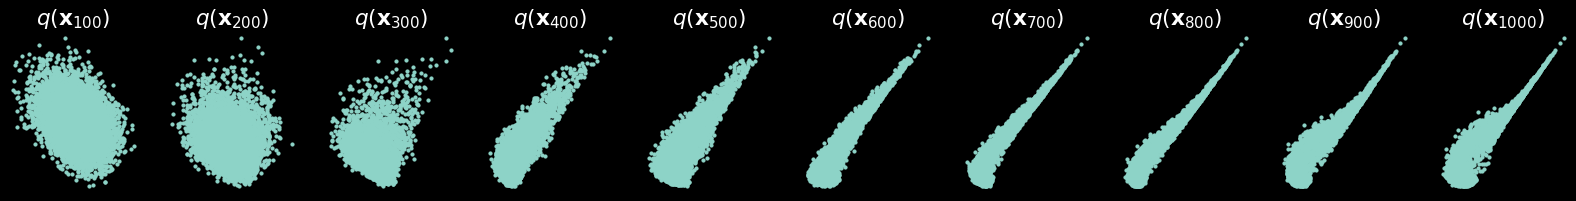

In [29]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
batch_size = 128
for t in tqdm(range(5001)):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = loss_likelihood_bound(model.to(device), batch_x.to(device))
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 1000 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0].to('cpu'), cur_x[:, 1].to('cpu'), s=10);
            axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## Denoising diffusion probabilistic models (DDPM)

최근 연구(Ho et al. [ [ 1 ] ](#ref1))에서는 생성 결과물의 품질을 향상시키는 몇몇 개선점을 포함한 diffusion model들이 제안되었다. 첫 째로, 'mean function'에 대해 아래처럼 parameterization을 제안했다.

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

- because..

$$
\mathbf{x}_{t} \sim q\left(\mathbf{x}_{t} \mid \mathbf{x}_{0}\right)=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0},\left(1-\bar{\alpha}_{t}\right) \mathbf{I}\right)
$$

$$
\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right)=\sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon} \text { for } \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

$$
\mathbf{x}_{0} = \frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right)-\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}\right)
$$

$$
\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right)=\tilde{\boldsymbol{\mu}}_{t}\left(\mathbf{x}_{t}, \frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(\mathbf{x}_{t}-\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}\right)\right)\right)=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}, t\right)\right)
$$

<img src="images/ddpm_mu_derivation.jpeg" width="100%">

모델은 noise function의 형식으로 직접 output을 뱉어내도록 학습된다. 이 noise function은 sampling process에서 사용된다. 게다가 저자는 fixed variance function을 사용하도록 제안한다.

$$
\mathbf{x}_{t-1} = \mu_{\theta}(x_{t}, t) + \sigma_{t}\mathbf{z} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}, \space\space\space \mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$


- because..
$$
\mathbf{x}_{t-1} \sim p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)\right)
$$

이는 reverse process에서 새로운 sampling procedure로 이어진다. 

In [30]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

    
def p_sample(model, x, t):
    
    t = torch.tensor([t]).to(device)
    
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x)).to(device)
    
    # Model output
    eps_theta = model(x, t).to(device)
    
    # Final values
    mean = (1 / extract(alphas.to(device), t, x).sqrt()) * (x - (eps_factor * eps_theta))
    
    # Generate z
    z = torch.randn_like(x).to(device)
    
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt().to(device)
    sample = mean + sigma_t * z
    
    return (sample)

_forward process posterior_ 는 $\mathbf{x}_{0}$가 조건부일 때도 tractable하다.

$$
q\left(\mathbf{x}_{t} \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}} \mathbf{x}_{t-1}, \beta_{t} \mathbf{I}\right)
$$

$$
q\left(\mathbf{x}_{t} \mid \mathbf{x}_{0}\right)=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0},\left(1-\bar{\alpha}_{t}\right) \mathbf{I}\right)
$$

그리고 이에 따른 _forward process posterior_ 의 mean $\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0})$과 variance $\tilde{\beta}$ 를 아래와 같이 정의할 수 있다.


\begin{align}
\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0}) &= \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_{t}}{1 - \bar{\alpha}_{t}}\mathbf{x}_{0} + \frac{\sqrt{\bar{\alpha}_{t}}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}\mathbf{x}_{t}\\
\tilde{\beta}_{t} &= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_{t}
\end{align}

## Training in DDPM

DDPM에서의 또 다른 개선은 'variance reduction'에 있다. 이는 Loss $\mathcal{L}$ 을 KL divergence의 합으로 표현하는 것에서 확인할 수 있다.

\begin{align}
\mathcal{L} &= \mathbb{E}_{q}\left[ \mathcal{L}_{T} + \sum_{t>1} \mathcal{L}_{t-1} + \mathcal{L}_{0} \right] \\
\mathcal{L}_{T} &= D_{KL}(q(\mathbf{x}_{T}\mid\mathbf{x}_{0}) \Vert p(\mathbf{x}_{T})) \\
\mathcal{L}_{t-1} &= D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})) \\
\mathcal{L}_{0} &= - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) 
\end{align}

모든 KL divergence들은 gaussians 분포들의 비교이다. 따라서 이들 모두 closed-form solution을 갖는다.

In [31]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

이는 아래와 같이 새로운 loss function으로 이어진다. (주목할 점은 이 objective는 최적화 그 자체로서는 큰 변화를 제공하지는 않는다는 점이다. "note that this objective does not provide large change to the optimization itself")

In [32]:
def loss_variational(model, x_0):
    
    batch_size = x_0.shape[0]
    
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    
    return output.mean(-1)

### Simplifying loss to denoising score matching

[ [ 1 ] ](#ref1) 연구는 reverse process의 평균에 대해 새로운 parameterization을 제안했다.

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1 - \alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

이 parameterization에 근거해, 연구는 training objective 를 아래와 같이 설정한다.

$$
\mathcal{L}_{t-1}-C=\mathbb{E}_{\mathbf{x}_{0},\mathbf{\epsilon}}\left[ \frac{\beta_{t}^{2}}{2\sigma_{t}^{2}\alpha_{t}(1-\bar{\alpha}_{t})} \Vert \epsilon_{t} - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right]
$$

이는 denoising score matching over multiple noise scales 와 유사하다.

#### Further simplified training objective

저자는 loss의 시작 시기에 있는 복잡한 부분(complicated factor)를 완전히 제거하는 것이 sample의 질에 상호 호혜적이라는 점을 의논한다. 이러한 논의는 결국 objective를 아래와 같이 요약한다.

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

이 objective는 denoising score matching 공식과 매우 유사함을 알 수 있다. 게다가 이는 굉장히 간단하게 코드 구현이 가능하다.

In [33]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    
    # Select a random step for each example of a batch(128)
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long().to(device)
    
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(device)
    
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(device)
    e = torch.randn_like(x_0).to(device)
    
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)  # model := e_{epsilon}(x, t)
    
    return (e - output).square().mean()

#### Stabilizing training with Exponential Moving Average (EMA) 

EMA 아이디어는 _model momentum_ 을 가능하게 하며, 거의 대부분의 구현체에서 사용되는 테크닉이다. 

모델의 weights를 직접 upate하는 대신, 우리는 weigts의 이전 process의 value들을 먼저 복사해 저장("shadow")해둔다. 그리고 과거와 현재의 weight값들을 서로 가중평균해 모델의 weights 예측을 update한다.

$$w_{1:t} = (1-\mu) \cdot w_{t} + \mu \cdot w_{1:(t-1)}, \space\space\space ex) \space \mu = 0.9$$

해당 코드는 [DDIM repository](https://github.com/ermongroup/ddim)를 참고해 작성됐다.

- [code](https://github.com/ermongroup/ddim/blob/51cb290f83049e5381b09a4cc0389f16a4a02cc9/runners/diffusion.py#L192)
    - Sample 과정에서 학습 시 저장해놓은 ema parameters들을 load해 사용할 수 있음
    - 현재 ipynb에서는 사용하지는 않음

In [34]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = torch.tensor(mu).to(device)
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone().to(device)

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

아래의 training loop를 통해 최적화를 할 수 있다.

```python
model, optimizer, dataset 선언
EMA model 생성

for Iterations 1000:
    
    for batch:
        
        loss 계산
        loss.backward
        
        weight update
        EMA update(weight moving average)

        
    if Iteration % 100 == 0:
       
        print(loss)
        reverse sampling 결과 visualization($x_{100}, ..., x_{1000}$)
```

In [ ]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()

# Create EMA model
ema = EMA(0.9)
ema.register(model)

# Batch size
batch_size = 128
for t in tqdm(range(1000)):
    
    # X is a torch Variable
    # shuffle batch elements per epoch
    permutation = torch.randperm(dataset.size()[0])
    
    for i in range(0, dataset.size()[0], batch_size):
        
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        
        # Compute the loss.
        loss = noise_estimation_loss(model.to(device), batch_x.to(device))
        
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        
        # Calling the step function to update the parameters
        optimizer.step()
        
        # Update the exponential moving average
        ema.update(model.to(device))
        
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model.to(device), dataset.shape)  # reverse sampling
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0].to('cpu'), cur_x[:, 1].to('cpu'), s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)


# Supplement

## torch.rand_like

**torch.rand_like()**


Returns a tensor with the same size as input that is filled with random numbers from a uniform distribution on the interval [0,1). ```torch.rand_like(input)``` is equivalent to ```torch.rand(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)```.

In [ ]:
print("max : ", torch.rand_like(torch.tensor(data)).max())
print("min : ", torch.rand_like(torch.tensor(data)).min())

## Normal distribution sampling을 해야 하는 것이 아닌가?

- tutorial에서 정의한 diffusion process는 정확히는 normal distribution에서 sampling하는 것이 아닌 듯 하다.
    - 단지 scaling과 transition을 하는 affine 연산으로 보인다.
    - 왜냐.. VAE에서 reparametrization trick을 사용한 것과 같은 이유다. 그리고 해당 식은 바로 gaussian sampling의 과정을 differentiable하게 정의한 reparametrization식과 같다.
    - 그럼에도 불구하고, parameter를 바꿔서 normal distribution에서 sampling하는 방식으로 바꿔서 forward process를 정의해봤다.
        - 과연 reparametrization trick과 어떤 차이가 있을까?

In [ ]:
from torch.distributions.normal import Normal

betas = torch.FloatTensor([0.035])
data = sample_batch(10**4).T

seq = [data]

# Normal(loc, scale).sample()을 활용해 재구성
m1 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m1.sample())

m2 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m2.sample())

m3 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m3.sample())

m4 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m4.sample())

m5 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m5.sample())

m6 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m6.sample())

m7 = Normal(torch.sqrt(1 - beta) * seq[-1], seq[-1].shape[0]*beta)
seq.append(m7.sample())

plt.scatter(*seq[-1], s=1, color='yellow')
plt.scatter(*seq[0], s=1)
plt.show()

위와 같이 점진적으로 normal distribution을 convert하면서 sampling을 해도, perturbation효과를 볼 수 있다. 

이러한 접근을 바탕으로 새롭게 _forward_process_js_ 를 정의하고, 기존 _forward_process_ 와의 차이를 살펴보자.

In [ ]:
def forward_process_js(x_start, n_steps, noise=None):
    '''
    Diffuse the data (t == 0 means diffused for 1 step) 
    
    x_start:tensor = dataset at start step(X_0)
    n_steps:int = the number of convert iterations in diffusion process
    '''
    x_seq = [x_start]
    for n in range(n_steps):
        new_dist = Normal(torch.sqrt(1-noise[n]) * x_seq[-1], 
                          x_seq[-1].shape[0] * noise[n])
        x_seq.append(new_dist.sample())
    
    return x_seq

우선, 총 10개의 step 변화만 살펴보자. normal distribution에서 샘플링을 진행하는 경우가 

- Normal sampling 연산이 시간 면에서 거의 2배 가량 더 소요된다.
- Normal sampling 연산이 동일한 noise(ex: beta=0.035)에서 perturbation되는 효과가 더 크다.
    - 따라서, Normal smapling으로 _forward process_를 하려면 noise 정도를 더욱 작게 가져가는 것이 좋다.
        - large number of small perturbations을 실현하려면..

In [ ]:
n_steps=10
betas = torch.tensor([0.035]*n_steps)
dataset = torch.tensor(data).float()

In [ ]:
%%timeit
x_seq = forward_process(dataset, n_steps, betas)

In [ ]:
%%timeit
x_seq_js = forward_process_js(dataset, n_steps, betas)

In [ ]:
x_seq = forward_process(dataset, n_steps, betas)
x_seq_js = forward_process_js(dataset, n_steps, betas)

In [ ]:
print(f"[10 STEP] forward process function (Affine transformation)")
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(*x_seq[i], s=10)  # |x_seq[i]| = (2, 10000)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i)+'})$')

In [ ]:
print(f"[10 STEP] forward process function (Normal sampling) with noise = 0.035")
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(*x_seq_js[i], s=10) # |x_seq_js[i]| = (2, 10000)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i)+'})$')

In [ ]:
x_seq_js2 = forward_process_js(dataset, n_steps, noise=torch.tensor([0.01]*10))

print(f"[10 STEP] forward process function (Normal sampling) with noise = 0.01")
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(*x_seq_js2[i], s=10) # |x_seq_js[i]| = (2, 10000)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i)+'})$')

## Variance Schedule methods

- Linear
- Quad
- Sigmoid

In [ ]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [ ]:
betas_linear = make_beta_schedule(schedule='linear')
betas_quad = make_beta_schedule(schedule='quad')
betas_sigmoid = make_beta_schedule(schedule='sigmoid')

In [ ]:
plt.title(f"Variance 'Linear' schedule")
plt.plot(betas_linear)
plt.show()

In [ ]:
plt.title(f"Variance 'Quad' schedule")
plt.plot(betas_quad)
plt.show()

In [ ]:
plt.title(f"Variance 'Sigmoid' schedule")
plt.plot(betas_sigmoid)
plt.show()

## torch.gather(input, dim, index)

- input — input tensor
- dim — dimension along to collect values
- index — tensor with indices of values to collect
```
여기서 중요한 것은 input과 index의 dimension이 동일해야 한다.
만약 인풋이 4x10x15이고, dim =0 이면 index는 Nx10x15 
즉 dim인 부분을 제외하고 나머지 차원은 동일해야 한다.
```

## VAE

**reference**

- https://youtu.be/GbCAwVVKaHY
- https://taeu.github.io/paper/deeplearning-paper-vae/

### What is the 'VAE' ?

- Maximization of "data likelihood $p_{\theta}(x)$" by training Encoder, Decoder.

<img src="images/vae_tuto1.png" width="100%">

VAE는 최초에 아래와 같은 sample이 속한 data의 true distribution( $p(x)$ )를 찾아내고자 했다. 이는 joint distribution의 mariginalization($dz$)으로 가능하다. 이렇게 $p(x)$ 를 찾아낼 수 있다. 이를 찾아내기 위해선 $p_{\theta}(z)$와 $p_{\theta}(x|z)$를 알아야 한다. 이 과정에서 사용되는 distribution은 알지 못하기 때문에 모델이 찾아내야 한다. 

곧 학습을 해야하는 것이고, 따라서 parameter를 $\theta$로 표현한다. 그래서 아래와 같은 식이 성립하고, $p_{\theta}(x)$가 극대화되도록 학습된다. 곧 모델이 추정한 분포(density estimation) $p_{\theta}(x)$가 실제 true data distribution과 가장 잘 정합한다면, $p_{\theta}(x)$의 값도 가장 커질 것이고 이러한 접근은 곧 Likelihood 극대화이다.

$$
{p_{\theta}(x)}=\int p_{\theta}(z) p_{\theta}(x \mid z) d z
$$

- 즉 likelihood를 극대화할 수 있는 $p_{\theta}(x)$를 찾아야 하고, 이를 찾기 위해선 2가지 pdf를 찾아내면 된다.

    1. prior distribution ( $p_{\theta}(z)$ )
    2. conditional distribution ( $p_{\theta}(x|z)$ ) : **Decoder network**
    
하지만 이 2가지를 직접 찾아내는 데에는 문제가 발생한다. 바로 직접 계산해내는 것이 불가능(intractable)하다는 것이다.

<img src="images/vae_tuto2.png" width="100%">

무엇이 불가능한가?

- 바로 $p_{\theta}(x|z)$를 모든 $z$에 대해 계산해내는 것이 불가능하다는 것이다. 즉, decoder network를 모든 $z$에 대해 계산해내는 것이 intractable 하다는 것이다.

- 위의 PPT 장표와 같이 각 요소들을 정의한다.
    - Prior : Simple gaussian prior
    - Conditional distribution : Decoder network
    

- **생각의 전환 : Posterior estimation => encoder network(Posterior $p(z|x)$)를 ELBO(evidence lower bound) 최적화**


- conditional distribution $p_{\theta}(x|z)$가 intractable하다면, $p_{\theta}(z|x)$는 어떨까? tractable하다면 $p_{\theta}(x|z)$를 구하는 데 도움이 될 것 같다.
    - $p_{\theta}(z|x)$를 안다면 $p_{\theta}(z)$를 알기 때문에, 어떻게든 $p_{\theta}(x|z)$ 계산이 가능하지 않을까 생각할 수 있기 때문이다.
    
$$p(z|x)p(x) = p(x|z)p(z)$$

    - 그리고 이것은 Posterior density estimation의 과정으로 연결된다.
- Bayes' Theorem에 따라 아래와 같이 posterior distribution으로 $p_{\theta}(z|x)$를 설정하고, 각 요소들(3개)을 최적화하면 된다.
    
$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$


- 하지만 $p_{\theta}(z|x)$는 intractable하다.
    - 당연하게도 $p_{\theta}(x)$와 $p_{\theta}(x|z)$도 모르기 때문에..


- 그렇다면 어떻게 해야할까? 어떻게 해야 Decoder Network ( $p_{\theta}(x|z)$ ) 를 찾아낼 수 있을까?
    - 모르면 Neural network로 설정하고, 학습시키면 된다.
    - 즉, $p_{\theta}(z|x)$를 찾게 한다. 어떻게? intractable 한데...
    
    
- 자 정리하면, intractable한 것이 2개가 나왔다. 

    1. $p_{\theta}(z|x)$
    2. $p_{\theta}(x|z)$


- 이 둘을 다 neural network로 설정해 찾기로 한다.

    - $p_{\theta}(x|z)$는 Decoder network로 설정해 직접 찾기로 한다. 최종적인 Posterior로 설정한다.
    - $p_{\theta}(z|x)$는 Encoder network로 **추가로** 설정해 학습시킨다.
        - Encoder network는 $q_{\phi}(z|x)$로 설정해 $p_{\theta}(z|x)$를 approximation하도록 한다.


- 그럼 최종적으로 정리하면 **Posterior**인 conditional distribution $p_{\theta}(x|z)$를 찾기 위해 아래와 같은 과정이 필요하다.

$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$

1. Prior distribution $p_{\theta}(z)$ 를 설정(보통 simple gaussian)
2. Likelihood $p_{\theta}(x|z)$ 를 Decoder network로 설정한다. 그리고 학습한다.
3. evidence $p_{\theta}(x)$ 를 최적화한다. (이 evidence는 'data likelihood'라고 부른다.)
4. 1.-3. 의 조합인 **Posterior**인 conditional distribution $p_{\theta}(z|x)$를 계산해낸다.


- 여기서 핵심은 중요하지 않아 보이던 **evidence**이다. 이 evidence는 lower bound를 갖는 데, 이 evidence(data likelihood)의 lower bound는 tractable하기 때문에 optimization이 가능하다.


- 그럼 각 3가지 요소는 아래와 같이 다 해결돼, Posterior를 찾을 수 있다.

    - prior(미리 정의, gaussian)
    - likelhood(encoder network, 학습과 최적화 가능)
    - evidence(ELBO 최적화 가능)

다시 처음으로 돌아가보자. 우리가 찾고자 했던 것은 무엇인가? 
```
VAE는 최초에 아래와 같은 sample이 속한 data의 true distribution( p(x) )를 찾아내고자 했다
```
라고 했었다.

그리고 위에서 정리한 것에 따르면, 이제 구할 수 있을 것 같다. 요약하면 Encoder($p_{\theta}(z|x)$), Decoder($p_{\theta}(x|z)$)를 $p(x)$ 최적화를 위해 학습시키면 아래의 Posterior를 찾을 수 있고, 자연스럽게 그 때의 True distribution $p_{\theta}(x)$도 찾을 수 있다.
- **Posterior(Encoder) $p_{\theta}(z|x)$ Optimization => Evidence(data likelihood $p_{\theta}(x)$) Optimization**

$$p_{\theta}(z|x) = \frac{p_{\theta}(x|z)p(z)}{p_{\theta}(x)}$$

$$p_{\theta}(x) = \frac{p_{\theta}(x|z)p_{\theta}(z)}{p_{\theta}(z|x)}$$


- 우리는 data likelihood($p_{\theta}(x)$)를 최대화(Maximization)하고 싶다.
- 최적화 대상인 data likelihood($p_{\theta}(x)$)는 아래의 PPT 장표의 정리와 같이 펼쳐진다.

#### Loss function(data likelihood, evidence) 유도

<img src="images/vae_tuto3.png" width="100%">
<img src="images/vae_tuto4.png" width="100%">
<img src="images/vae_tuto5.png" width="100%">
<img src="images/vae_tuto6.png" width="100%">
<img src="images/vae_tuto7.png" width="100%">

결국 위의 Loss function의 각 Reconstruction과 Regularization 파트를 전체 VAE 도식에서 정리하면 아래와 같다.

<img src="images/VAE.png" width="100%">
<img src="images/VAE2.png" width="100%">

#### Regularization Error

- Minimization **KL divergence** between "Latent distribution" and "Normal distribution"

<img src="images/vae_tuto8.png" width="100%">
<img src="images/vae_tuto9.png" width="100%">


위 식에서 $N_{1}$은 Assumption 2에서 언급했 듯, $N(0, I)$를 가정했기 때문에, 평균과 공분산 행렬이 모두 0과 I로 주어진다. 

따라서, "KLD for Multivariate normal distribution"은 $
\frac{1}{2} \sum_{j=1}^{J}\left(\mu_{i, j}^{2}+\sigma_{i, j}^{2}-\ln \left(\sigma_{i, j}^{2}\right)-1\right)
$ 로 정리되고, 이것이 바로 Regularization loss part 수식이 된다.

#### Reconstruction Error

- **Cross Entropy** on "$p(x_{i,j})$" and "$1-p(x_{i,j})$"
    - $H[p, q:(1-p)]$
    - Bernoulli distribution( $p$ )
    
    
- output의 확률분포를 Normal distribution으로 가정할 경우,
    - Loss function은 MSE로 표현될 수 있음
    
    
- output의 확률분포를 Bernoulli distribution으로 가정할 경우, 
    - Loss function은 Cross Entropy로 표현될 수 있음
    - VAE는 Decoder의 output을 Bernoulli distribution을 따른다고 가정하고, Cross Entropy를 바탕으로 아래와 같이 Loss function의 Reconstruction Error를 정의한다.
    
    
- Loss function(Reconstruction Error) of VAE    

$$
-\mathbb{E}_{q_{\phi}\left(z \mid x_{i}\right)}\left[\log \left(p\left(x_{i} \mid g_{\theta}(z)\right)\right)\right]
$$

$$
-\sum_{j=1}^{D} x_{i, j} \log p_{i, j}+\left(1-x_{i, j}\right) \log \left(1-p_{i, j}\right)
$$

- $q_{\phi}\left(z \mid x_{i}\right)$는 Encoder network
- $g_{\theta}\left(z\right)$는 Decoder network


##### Reconstruction Error 1 : Expectation은 Monte-carlo simulation으로 대체

<img src="images/vae_tuto10.png" width="100%">


Reconstruction Error는 기대값이기 때문에, 연속적인 공간에서 적분이 필요하다. 하지만 모든 $z$에 대해 값을 계산하는 적분은 **intractable**하다. 따라서 직접 계산할 수 없으니 approximation하는 **Monte-carlo technique**을 활용하기로 한다. 모든 $z$가 아니라 $L$개 만큼 sampling한 $z$에 대해 $log(p_{\theta}(x_{i}|z)$를 계산해 평균을 취하는 것이다.


하지만 **Monte-carlo technique**을 사용했다는 선언이 무안하게.. 보통 $L$번의 샘플링을 하기 보단 1번의 샘플링으로 값을 대체한다. 결국, 1번만 sampling해서 Reconstruction error를 구해주는 것이다.


##### Reconstruction Error 2 : Reconstruction Error를 구하기 위한 latent sampling은 Reparameterization Trick으로 대체

<img src="images/vae_tuto11.png" width="100%">


그리고 Reconstruction error를 구하기 위해 사용되는 것이 바로 **Reparameterization Trick**이다. 위의 장표와 같이 왼쪽의 경우가 정말 우리가 하고 싶었던 부분이다. 즉, Encoder를 통해 얻어낸 모수를 통해 normal distribution을 상정하고 sampling을 진행해 Decoder에 넣어주는 것이다. 하지만 본래 Neural network란 auto-differentiation을 위해 gradient가 전파되어어야 한다. 


하지만 이 **sampling은 미분이 불가능하다.**


따라서 이 과정을 미분 가능하게 바꿔주는 것이 바로 **Reparameterization Trick**이다. **Reparameterization Trick**의 컨셉은 간단하다. 결국에 우리가 필요한 것은 Decoder에 넘겨줄 sample이다(Encoder로부터 얻은 latent distribution에서 추출한). 


직접 Encoder에서 얻은 latent distribution에서 sampling하지 않고, **standard normal distribution에서 sampling을 해서 latent distribution으로 옮겨줄 것이다.** 이는 scaling($\sigma$)과 transition($\mu$)과정은 단순 곱셈과 덧셈 연산으로 Auto-differentiation에 전혀 문제가 되지 않는다. 이 과정은 위 장표의 도식으로 쉽게 이해할 수 있다.


##### Reconstruction Error 3 : Decoder를 Bernoulli distribution으로 가정

<img src="images/vae_tuto12.png" width="100%">

$p_{\theta}(x_{i}|z)$를 bernoulli로 가정할 수 있다. 이 경우, output의 각 dimension(pixel)마다 bernoulli distribution의 probability값(parameter)들이 할당될 것이다. 이 각 dim의 probaility값들을 log proability로 모두 더해주면 결국 Cross Entropy가 된다. 결국 Bernoulli distribution을 따르는 output probability의 Reconstruction Error는 Cross Entropy가 되는 것이다.


**만약 Decoder를 Normal distribution으로 가정하면 Reconstruction Error는 MSE**가 된다. 이 경우, Decoder는 각 dimension(pixel)마다 $\mu$, $\sigma$(parameter)들이 할당된다.

<img src="images/vae_tuto13.png" width="100%">


따라서 Default로는 아래와 같이 Gaussian Encoder(output : Gaussian parameters), Bernoulli Decoder(output : bernoulli parameter $p$)로 풀어준다.

<img src="images/vae_tuto14.png" width="100%">


그리고 Gaussian Encoder, Decoder를 사용했을 때 Covariate matrix 가정에 따른 각 상황은 아래와 같다.

<img src="images/vae_tuto15.png" width="100%">

<img src="images/vae_tuto16.png" width="100%">

### VAE vs DDPM(diffusion)

- DDPM의 forward diffusion process는 학습 대상이 아니다(VAE의 Encoder와 달리).
- DDPM의 forward, reverse process는 모두 Markov chain process이다.
- 비록 latent variable을 단계적으로 층층이 쌓는 모습은 Hierarchical VAE와 유사하지만, DDPM이 갖는 특징은 차별점을 가짐.
    - latent variable의 dimension이 유지
    - Encoder가 learnable하지 않음 (Fixed diffusion process with variance schedule)

<img src="images/vae_ddpm.jpeg" width="100%">

## Loss function of DDPM(diffusion)

<img src="images/lossfunction_ddpm1.jpeg" width="100%">
<img src="images/lossfunction_ddpm2.jpeg" width="100%">

### Supplement : Derivation of Loss function of DDPM

- original paper : [Denoising Diffusion Probabilistic Models (2020)](https://arxiv.org/abs/2006.11239)
- reference : https://developers-shack.tistory.com/8

# Bibliography

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

### Inspiration and sources

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb
https://github.com/ermongroup/sliced_score_matching